In [59]:
import requests
from bs4 import BeautifulSoup
import sqlite3
import time
import random
from datetime import datetime, timedelta
import re
import json
import csv
from collections import defaultdict, Counter

try:
    import matplotlib.pyplot as plt
    MATPLOTLIB_AVAILABLE = True
    plt.rcParams['figure.figsize'] = (12, 8)
    plt.rcParams['font.size'] = 12
except ImportError:
    MATPLOTLIB_AVAILABLE = False

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class DataFrameReplacement:
    """Simple replacement for pandas DataFrame."""
    
    def __init__(self, data=None, columns=None):
        if data is None:
            self.data = []
            self.columns = columns or []
        elif isinstance(data, list) and data and isinstance(data[0], dict):
            self.data = data
            self.columns = list(data[0].keys()) if data else []
        else:
            self.data = data if isinstance(data, list) else []
            self.columns = columns or []
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, key):
        if isinstance(key, str):
            return [row.get(key) for row in self.data]
        return self.data[key]
    
    @property
    def empty(self):
        return len(self.data) == 0
    
    def head(self, n=5):
        return DataFrameReplacement(self.data[:n])
    
    def iterrows(self):
        for i, row in enumerate(self.data):
            yield i, row
    
    def groupby(self, column):
        groups = defaultdict(list)
        for row in self.data:
            key = row.get(column)
            groups[key].append(row)
        return DataFrameGroupBy(groups)
    
    def mean(self, column=None):
        if column:
            values = [row.get(column, 0) for row in self.data if isinstance(row.get(column), (int, float))]
            return sum(values) / len(values) if values else 0
        return None


class DataFrameGroupBy:
    
    def __init__(self, groups):
        self.groups = groups
    
    def agg(self, agg_dict):
        results = []
        for key, group_data in self.groups.items():
            result = {'group_key': key}
            for column, operations in agg_dict.items():
                if isinstance(operations, str):
                    operations = [operations]
                
                for op in operations:
                    if op == 'count':
                        result[column] = len(group_data)
                    elif op == 'sum':
                        values = [row.get(column, 0) for row in group_data if isinstance(row.get(column), (int, float))]
                        result[column] = sum(values)
                    elif op == 'max':
                        values = [row.get(column, 0) for row in group_data if isinstance(row.get(column), (int, float))]
                        result[column] = max(values) if values else 0
                    elif op == 'first':
                        result[column] = group_data[0].get(column) if group_data else None
            results.append(result)
        
        return DataFrameReplacement(results)


class GitHubTrendingCrawler:
    
    def __init__(self, db_path='github_trending.db'):
        self.db_path = db_path
        self.base_url = 'https://github.com/trending'
        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
            'Accept-Language': 'en-US,en;q=0.5',
            'Connection': 'keep-alive',
        }
        self.session = requests.Session()
        self.session.headers.update(self.headers)
        self.init_database()
    
    def init_database(self):
        try:
            with sqlite3.connect(self.db_path) as conn:
                cursor = conn.cursor()
                
                cursor.execute('''
                    CREATE TABLE IF NOT EXISTS trending_repos (
                        id INTEGER PRIMARY KEY AUTOINCREMENT,
                        repo_name TEXT NOT NULL,
                        author TEXT NOT NULL,
                        description TEXT,
                        language TEXT,
                        total_stars INTEGER,
                        total_forks INTEGER,
                        today_stars INTEGER,
                        repo_url TEXT,
                        crawl_date DATE,
                        created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
                        UNIQUE(repo_name, author, crawl_date)
                    )
                ''')
                
                # Add growth tracking table
                cursor.execute('''
                    CREATE TABLE IF NOT EXISTS daily_growth (
                        id INTEGER PRIMARY KEY AUTOINCREMENT,
                        repo_name TEXT NOT NULL,
                        author TEXT NOT NULL,
                        date DATE NOT NULL,
                        stars_gained INTEGER DEFAULT 0,
                        forks_gained INTEGER DEFAULT 0,
                        growth_rate REAL DEFAULT 0.0,
                        UNIQUE(repo_name, author, date)
                    )
                ''')
                
                # Add language trends table
                cursor.execute('''
                    CREATE TABLE IF NOT EXISTS language_trends (
                        id INTEGER PRIMARY KEY AUTOINCREMENT,
                        language TEXT NOT NULL,
                        date DATE NOT NULL,
                        project_count INTEGER DEFAULT 0,
                        total_stars INTEGER DEFAULT 0,
                        avg_stars REAL DEFAULT 0.0,
                        momentum_score REAL DEFAULT 0.0,
                        UNIQUE(language, date)
                    )
                ''')
                
                indexes = [
                    'CREATE INDEX IF NOT EXISTS idx_growth_date ON daily_growth(date)',
                    'CREATE INDEX IF NOT EXISTS idx_trends_date ON language_trends(date)',
                    'CREATE INDEX IF NOT EXISTS idx_repo_date ON trending_repos(repo_name, author, crawl_date)',
                    'CREATE INDEX IF NOT EXISTS idx_language ON trending_repos(language)',
                ]
                
                for index_sql in indexes:
                    cursor.execute(index_sql)
                
                conn.commit()
            
            print("Enhanced database initialized successfully")
            
        except sqlite3.Error as e:
            print(f"Database initialization failed: {e}")
            raise
    
    def extract_number(self, text):
        if not text:
            return 0
        
        text = re.sub(r'[^\d.km]', '', text.lower().strip())
        if not text:
            return 0
            
        try:
            if 'k' in text:
                return int(float(text.replace('k', '')) * 1000)
            elif 'm' in text:
                return int(float(text.replace('m', '')) * 1000000)
            else:
                return int(float(text))
        except (ValueError, TypeError):
            return 0
    
    def crawl_trending_page(self, date_range='daily'):
        url = f"{self.base_url}?since={date_range}"
        print(f"Crawling GitHub trending: {url}")
        
        try:
            response = self.session.get(url, timeout=30)
            response.raise_for_status()
            
            soup = BeautifulSoup(response.content, 'html.parser')
            repositories = []
            
            repo_items = soup.find_all('article', class_='Box-row')
            
            for item in repo_items:
                try:
                    repo_data = self._parse_repository_item(item)
                    if repo_data:
                        repositories.append(repo_data)
                except Exception as e:
                    print(f"Error parsing repository item: {e}")
                    continue
            
            print(f"Successfully extracted {len(repositories)} repositories")
            return repositories
            
        except requests.RequestException as e:
            print(f"Network request failed: {e}")
            return []
        except Exception as e:
            print(f"Crawling error: {e}")
            return []
    
    def _parse_repository_item(self, item):
        try:
            title_element = item.find('h2', class_='h3')
            if not title_element:
                return None
                
            link = title_element.find('a')
            if not link:
                return None
                
            repo_path = link.get('href', '').strip('/')
            if '/' not in repo_path:
                return None
                
            author, repo_name = repo_path.split('/', 1)
            repo_url = f"https://github.com/{repo_path}"
            
            desc_element = item.find('p', class_='col-9')
            description = desc_element.get_text(strip=True) if desc_element else ""
            
            lang_element = item.find('span', {'itemprop': 'programmingLanguage'})
            language = lang_element.get_text(strip=True) if lang_element else "Unknown"
            
            stats = item.find_all('a', class_='Link--muted')
            total_stars = 0
            total_forks = 0
            
            for stat in stats:
                text = stat.get_text(strip=True)
                href = stat.get('href', '').lower()
                
                if 'star' in href:
                    total_stars = self.extract_number(text)
                elif 'fork' in href:
                    total_forks = self.extract_number(text)
            
            # Enhanced today stars extraction
            today_stars = 0
            today_elements = item.find_all('span', class_='d-inline-block')
            for elem in today_elements:
                text = elem.get_text(strip=True)
                if 'star' in text.lower() and ('today' in text.lower() or any(char.isdigit() for char in text)):
                    today_stars = self.extract_number(text)
                    break
            
            return {
                'repo_name': repo_name,
                'author': author,
                'description': description,
                'language': language,
                'total_stars': total_stars,
                'total_forks': total_forks,
                'today_stars': today_stars,
                'repo_url': repo_url,
                'crawl_date': str(datetime.now().date())
            }
            
        except Exception as e:
            print(f"Failed to parse repository item: {e}")
            return None
    
    def save_to_database(self, repositories):
        if not repositories:
            print("No repository data to save")
            return
        
        try:
            with sqlite3.connect(self.db_path) as conn:
                cursor = conn.cursor()
                today = str(datetime.now().date())
                
                saved_count = 0
                for repo in repositories:
                    # Save main repository data
                    try:
                        cursor.execute('''
                            INSERT OR REPLACE INTO trending_repos 
                            (repo_name, author, description, language, total_stars, 
                             total_forks, today_stars, repo_url, crawl_date)
                            VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
                        ''', (
                            repo['repo_name'], repo['author'], repo['description'],
                            repo['language'], repo['total_stars'], repo['total_forks'],
                            repo['today_stars'], repo['repo_url'], repo['crawl_date']
                        ))
                        
                        # Track daily growth
                        if repo['today_stars'] > 0:
                            growth_rate = (repo['today_stars'] / max(repo['total_stars'] - repo['today_stars'], 1)) * 100
                            cursor.execute('''
                                INSERT OR REPLACE INTO daily_growth
                                (repo_name, author, date, stars_gained, growth_rate)
                                VALUES (?, ?, ?, ?, ?)
                            ''', (
                                repo['repo_name'], repo['author'], today,
                                repo['today_stars'], growth_rate
                            ))
                        
                        saved_count += 1
                    except sqlite3.Error as e:
                        print(f"Failed to save repository {repo['repo_name']}: {e}")
                
                # Update language trends
                self._update_language_trends(cursor, repositories, today)
                
                conn.commit()
            
            print(f"Successfully saved {saved_count} repositories to database")
            
        except sqlite3.Error as e:
            print(f"Database operation failed: {e}")
    
    def _update_language_trends(self, cursor, repositories, date):
        lang_stats = {}
        
        for repo in repositories:
            lang = repo['language']
            if lang not in lang_stats:
                lang_stats[lang] = {'count': 0, 'total_stars': 0}
            lang_stats[lang]['count'] += 1
            lang_stats[lang]['total_stars'] += repo['total_stars']
        
        for lang, stats in lang_stats.items():
            avg_stars = stats['total_stars'] / stats['count'] if stats['count'] > 0 else 0
            
            cursor.execute('''
                INSERT OR REPLACE INTO language_trends
                (language, date, project_count, total_stars, avg_stars)
                VALUES (?, ?, ?, ?, ?)
            ''', (lang, date, stats['count'], stats['total_stars'], avg_stars))
    
    def collect_multi_day_data(self, days=14):
        print(f"Starting enhanced {days}-day data collection")
        
        for day in range(days):
            try:
                print(f"Collecting data for day {day + 1}/{days}")
                repositories = self.crawl_trending_page()
                self.save_to_database(repositories)
                
                # Show progress
                if repositories:
                    total_today_stars = sum(r['today_stars'] for r in repositories)
                    print(f"  └─ Collected {len(repositories)} repos with {total_today_stars} total daily stars")
                
                if day < days - 1:
                    wait_time = random.randint(60, 180)
                    print(f"  └─ Waiting {wait_time} seconds before next request")
                    time.sleep(wait_time)
                    
            except Exception as e:
                print(f"Data collection failed for day {day + 1}: {e}")
                continue
        
        print("Enhanced multi-day data collection completed")


class EnhancedGitHubAnalyzer:
    
    def __init__(self, db_path='github_trending.db'):
        self.db_path = db_path
    
    def load_data(self, days=14):
        """Load data with enhanced querying."""
        try:
            with sqlite3.connect(self.db_path) as conn:
                cursor = conn.cursor()
                end_date = datetime.now().date()
                start_date = end_date - timedelta(days=days-1)
                
                query = '''
                    SELECT * FROM trending_repos 
                    WHERE crawl_date BETWEEN ? AND ?
                    ORDER BY crawl_date DESC, total_stars DESC
                '''
                
                cursor.execute(query, (start_date, end_date))
                rows = cursor.fetchall()
                columns = [description[0] for description in cursor.description]
                
                data = [dict(zip(columns, row)) for row in rows]
            
            print(f"Loaded {len(data)} records from database")
            return DataFrameReplacement(data)
            
        except Exception as e:
            print(f"Data loading failed: {e}")
            return DataFrameReplacement()
    
    def get_daily_growth_leaders(self, days=7):
        try:
            with sqlite3.connect(self.db_path) as conn:
                cursor = conn.cursor()
                
                query = '''
                    SELECT tr.repo_name, tr.author, tr.language, tr.total_stars,
                           dg.stars_gained, dg.growth_rate, dg.date
                    FROM daily_growth dg
                    JOIN trending_repos tr ON dg.repo_name = tr.repo_name 
                                            AND dg.author = tr.author
                    WHERE dg.date >= date('now', '-{} days')
                    ORDER BY dg.stars_gained DESC
                    LIMIT 20
                '''.format(days)
                
                cursor.execute(query)
                results = cursor.fetchall()
                
                growth_data = []
                for row in results:
                    growth_data.append({
                        'repo_name': row[0],
                        'author': row[1],
                        'language': row[2],
                        'total_stars': row[3],
                        'stars_gained': row[4],
                        'growth_rate': row[5],
                        'date': row[6]
                    })
                
                return DataFrameReplacement(growth_data)
                
        except Exception as e:
            print(f"Growth analysis failed: {e}")
            return DataFrameReplacement()
    
    def analyze_language_momentum(self, days=30):
        try:
            with sqlite3.connect(self.db_path) as conn:
                cursor = conn.cursor()
                
                # Get language trends over time
                query = '''
                    SELECT language, date, project_count, avg_stars
                    FROM language_trends
                    WHERE date >= date('now', '-{} days')
                    ORDER BY language, date
                '''.format(days)
                
                cursor.execute(query)
                results = cursor.fetchall()
                
                # Calculate momentum for each language
                language_data = {}
                for lang, date, count, avg_stars in results:
                    if lang not in language_data:
                        language_data[lang] = []
                    language_data[lang].append({
                        'date': date,
                        'count': count,
                        'avg_stars': avg_stars
                    })
                
                momentum_analysis = {}
                for lang, data_points in language_data.items():
                    if len(data_points) >= 7:  # Need at least a week of data
                        # Calculate trend
                        recent_avg = sum(p['count'] for p in data_points[-7:]) / 7
                        older_avg = sum(p['count'] for p in data_points[:7]) / 7
                        
                        momentum = ((recent_avg - older_avg) / max(older_avg, 1)) * 100
                        
                        momentum_analysis[lang] = {
                            'momentum_percent': momentum,
                            'recent_avg': recent_avg,
                            'older_avg': older_avg,
                            'trend_direction': 'rising' if momentum > 5 else 'declining' if momentum < -5 else 'stable'
                        }
                
                return momentum_analysis
                
        except Exception as e:
            print(f"Momentum analysis failed: {e}")
            return {}
    
    def compare_time_periods(self, days1=7, days2=14):
        try:
            with sqlite3.connect(self.db_path) as conn:
                cursor = conn.cursor()
                
                # Recent period
                query1 = '''
                    SELECT language, COUNT(*) as count, AVG(total_stars) as avg_stars
                    FROM trending_repos
                    WHERE crawl_date >= date('now', '-{} days')
                    GROUP BY language
                    ORDER BY count DESC
                '''.format(days1)
                
                cursor.execute(query1)
                recent_data = {row[0]: {'count': row[1], 'avg_stars': row[2]} for row in cursor.fetchall()}
                
                # Older period
                query2 = '''
                    SELECT language, COUNT(*) as count, AVG(total_stars) as avg_stars
                    FROM trending_repos
                    WHERE crawl_date BETWEEN date('now', '-{} days') AND date('now', '-{} days')
                    GROUP BY language
                    ORDER BY count DESC
                '''.format(days2, days1)
                
                cursor.execute(query2)
                older_data = {row[0]: {'count': row[1], 'avg_stars': row[2]} for row in cursor.fetchall()}
                
                # Calculate changes
                comparison = {}
                all_languages = set(recent_data.keys()) | set(older_data.keys())
                
                for lang in all_languages:
                    recent = recent_data.get(lang, {'count': 0, 'avg_stars': 0})
                    older = older_data.get(lang, {'count': 0, 'avg_stars': 0})
                    
                    count_change = recent['count'] - older['count']
                    count_percent = (count_change / max(older['count'], 1)) * 100
                    
                    comparison[lang] = {
                        'recent_count': recent['count'],
                        'older_count': older['count'],
                        'count_change': count_change,
                        'percent_change': count_percent,
                        'recent_avg_stars': recent['avg_stars'],
                        'older_avg_stars': older['avg_stars']
                    }
                
                return comparison
                
        except Exception as e:
            print(f"Time period comparison failed: {e}")
            return {}
    
    def get_highest_growth_today(self, limit=20):
        return self.get_daily_growth_leaders(days=1)
    
    def generate_predictions(self, days=30):
        momentum = self.analyze_language_momentum(days)
        comparison = self.compare_time_periods(7, 14)
        
        predictions = {
            'rising_languages': [],
            'declining_languages': [],
            'stable_high_volume': [],
            'emerging_languages': []
        }
        
        for lang, data in momentum.items():
            if data['momentum_percent'] > 15:
                predictions['rising_languages'].append((lang, data))
            elif data['momentum_percent'] < -15:
                predictions['declining_languages'].append((lang, data))
            elif data['recent_avg'] > 5 and abs(data['momentum_percent']) < 10:
                predictions['stable_high_volume'].append((lang, data))
        
        # Find emerging languages (languages with small counts but high growth)
        for lang, comp_data in comparison.items():
            if (comp_data['recent_count'] < 5 and 
                comp_data['percent_change'] > 100 and 
                comp_data['recent_avg_stars'] > 1000):
                predictions['emerging_languages'].append((lang, comp_data))
        
        # Sort by momentum/growth
        predictions['rising_languages'].sort(key=lambda x: x[1]['momentum_percent'], reverse=True)
        predictions['declining_languages'].sort(key=lambda x: x[1]['momentum_percent'])
        predictions['stable_high_volume'].sort(key=lambda x: x[1]['recent_avg'], reverse=True)
        
        return predictions
    
    def generate_enhanced_report(self, days=14):
        print("Generating enhanced comprehensive analysis report...")
        
        # Load basic data
        df = self.load_data(days)
        if df.empty:
            print("No data available for analysis")
            return None, None, None, None
        
        # Basic analysis
        top_by_stars = self.get_top_repositories(df, 'total_stars', 20)
        top_by_forks = self.get_top_repositories(df, 'total_forks', 20)
        language_stats = self.analyze_programming_languages(df)
        
        # Enhanced features
        daily_growth_leaders = self.get_daily_growth_leaders(days)
        highest_growth_today = self.get_highest_growth_today()
        predictions = self.generate_predictions(days)
        time_comparison = self.compare_time_periods(7, 14)
        
        # Print enhanced report
        self._print_enhanced_report(
            df, language_stats, top_by_stars, top_by_forks,
            daily_growth_leaders, highest_growth_today, predictions,
            time_comparison, days
        )
        
        # Generate visualizations
        self.create_enhanced_visualizations(language_stats, predictions)
        
        print("Enhanced comprehensive report generated successfully")
        return df, language_stats, top_by_stars, top_by_forks
    
    def get_top_repositories(self, df, metric='total_stars', limit=20):
        if df.empty:
            return DataFrameReplacement()
        
        unique_repos = {}
        for row in df.data:
            key = (row['author'], row['repo_name'])
            if key not in unique_repos or row[metric] > unique_repos[key][metric]:
                unique_repos[key] = row
        
        sorted_repos = sorted(unique_repos.values(), key=lambda x: x[metric], reverse=True)
        return DataFrameReplacement(sorted_repos[:limit])
    
    def analyze_programming_languages(self, df):
        if df.empty:
            return DataFrameReplacement()
        
        lang_groups = df.groupby('language')
        lang_stats = lang_groups.agg({
            'repo_name': 'count',
            'total_stars': 'sum',
            'total_forks': 'sum'
        })
        
        results = []
        for row in lang_stats.data:
            results.append({
                'language': row['group_key'],
                'project_count': row['repo_name'],
                'total_stars': row['total_stars'],
                'total_forks': row['total_forks']
            })
        
        results.sort(key=lambda x: x['project_count'], reverse=True)
        return DataFrameReplacement(results)
    
    def _print_enhanced_report(self, df, language_stats, top_by_stars, top_by_forks,
                              daily_growth, highest_growth_today, predictions,
                              time_comparison, days):
        unique_keys = set((row['author'], row['repo_name']) for row in df.data)
        unique_projects = len(unique_keys)
        
        print("=" * 100)
        print("ENHANCED GITHUB TRENDING ANALYSIS REPORT")
        print("=" * 100)
        print(f"Analysis Period: {days} days")
        print(f"Total Records: {len(df):,}")
        print(f"Unique Projects: {unique_projects:,}")
        print(f"Report Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print()
        
        print("🌟 TOP 10 REPOSITORIES BY STARS")
        print("-" * 80)
        for i, row in enumerate(top_by_stars.data[:10], 1):
            print(f"{i:2d}. {row['author']}/{row['repo_name']:<30} "
                  f"⭐{row['total_stars']:>7,} 🍴{row['total_forks']:>6,} [{row['language']}]")
        print()
        
        print("🍴 TOP 10 REPOSITORIES BY FORKS")
        print("-" * 80)
        for i, row in enumerate(top_by_forks.data[:10], 1):
            print(f"{i:2d}. {row['author']}/{row['repo_name']:<30} "
                  f"🍴{row['total_forks']:>6,} ⭐{row['total_stars']:>7,} [{row['language']}]")
        print()
        
        # NEW: Daily Growth Leaders
        print("🚀 DAILY GROWTH LEADERS (Last 7 Days)")
        print("-" * 80)
        if not daily_growth.empty:
            for i, row in enumerate(daily_growth.data[:10], 1):
                print(f"{i:2d}. {row['author']}/{row['repo_name']:<25} "
                      f"+{row['stars_gained']:>4,} stars ({row['growth_rate']:>5.1f}%) [{row['language']}]")
        else:
            print("No daily growth data available")
        print()

        print("⚡ HIGHEST GROWTH TODAY")
        print("-" * 60)
        if not highest_growth_today.empty:
            for i, row in enumerate(highest_growth_today.data[:10], 1):
                if row['stars_gained'] > 0:
                    print(f"{i:2d}. {row['author']}/{row['repo_name']:<25} "
                          f"+{row['stars_gained']:>4,} stars today [{row['language']}]")
        else:
            print("No growth data available for today")
        print()
        
        print("📈 TREND PREDICTIONS & MOMENTUM ANALYSIS")
        print("-" * 80)
        
        if predictions['rising_languages']:
            print("🔥 RISING LANGUAGES (Strong upward momentum):")
            for lang, data in predictions['rising_languages'][:5]:
                print(f"  • {lang:<20} +{data['momentum_percent']:>6.1f}% momentum")
            print()
        
        if predictions['declining_languages']:
            print("📉 DECLINING LANGUAGES (Losing momentum):")
            for lang, data in predictions['declining_languages'][:5]:
                print(f"  • {lang:<20} {data['momentum_percent']:>7.1f}% momentum")
            print()
        
        if predictions['emerging_languages']:
            print("🌱 EMERGING LANGUAGES (Small but growing fast):")
            for lang, data in predictions['emerging_languages'][:3]:
                print(f"  • {lang:<20} +{data['percent_change']:>6.1f}% growth")
            print()
        
        if predictions['stable_high_volume']:
            print("⚖️ STABLE HIGH-VOLUME LANGUAGES:")
            for lang, data in predictions['stable_high_volume'][:5]:
                print(f"  • {lang:<20} {data['recent_avg']:>6.1f} avg daily projects")
            print()

        print("📊 RECENT vs PREVIOUS PERIOD COMPARISON (7 days vs prior 7 days)")
        print("-" * 80)
        if time_comparison:
            # Sort by percent change
            sorted_comparison = sorted(
                time_comparison.items(), 
                key=lambda x: x[1]['percent_change'], 
                reverse=True
            )
            
            print("Biggest gainers:")
            for lang, data in sorted_comparison[:5]:
                if data['count_change'] > 0:
                    print(f"  • {lang:<15} +{data['count_change']:>2} projects (+{data['percent_change']:>5.1f}%)")
            
            print("\nBiggest declines:")
            for lang, data in sorted(sorted_comparison, key=lambda x: x[1]['percent_change'])[:5]:
                if data['count_change'] < 0:
                    print(f"  • {lang:<15} {data['count_change']:>3} projects ({data['percent_change']:>6.1f}%)")
        print()

        print("💻 PROGRAMMING LANGUAGE STATISTICS (Top 10)")
        print("-" * 70)
        print(f"{'Language':<15} {'Projects':<8} {'Total Stars':<12} {'Total Forks':<10}")
        print("-" * 70)
        for row in language_stats.data[:10]:
            print(f"{row['language']:<15} {row['project_count']:<8} "
                  f"{row['total_stars']:<12,} {row['total_forks']:<10,}")
        print()

        print("📈 ENHANCED STATISTICAL INSIGHTS")
        print("-" * 50)
        
        avg_stars = df.mean('total_stars')
        avg_forks = df.mean('total_forks') 
        avg_today_stars = df.mean('today_stars')
        
        print(f"Average Stars per Project: {avg_stars:.0f}")
        print(f"Average Forks per Project: {avg_forks:.0f}")
        print(f"Average Daily New Stars: {avg_today_stars:.1f}")
        
        if language_stats.data:
            top_language = language_stats.data[0]
            print(f"Most Popular Language: {top_language['language']} ({top_language['project_count']} projects)")

        total_daily_growth = sum(row['today_stars'] for row in df.data)
        active_growth_projects = len([row for row in df.data if row['today_stars'] > 0])
        
        print(f"Total Daily Stars Gained: {total_daily_growth:,}")
        print(f"Projects with Daily Growth: {active_growth_projects} ({active_growth_projects/len(df)*100:.1f}%)")
        print()

        print("🔍 ENHANCED KEY FINDINGS & INSIGHTS")
        print("-" * 50)
        
        if language_stats.data:
            top_lang = language_stats.data[0]
            lang_percent = (top_lang['project_count'] / len(df) * 100)
            print(f"• {top_lang['language']} dominates with {lang_percent:.1f}% of all trending projects")
        
        high_star_count = sum(1 for row in df.data if row['total_stars'] >= 1000)
        print(f"• {high_star_count} projects ({high_star_count/len(df)*100:.1f}%) have 1000+ stars")
        
        mega_projects = sum(1 for row in df.data if row['total_stars'] >= 10000)
        print(f"• {mega_projects} projects ({mega_projects/len(df)*100:.1f}%) are mega projects (10k+ stars)")
        
        engagement_ratios = [row['total_forks'] / max(row['total_stars'], 1) for row in df.data]
        avg_engagement = sum(engagement_ratios) / len(engagement_ratios) if engagement_ratios else 0
        print(f"• Average community engagement ratio (forks/stars): {avg_engagement:.3f}")
        
        if not daily_growth.empty:
            rapid_growth = len([row for row in daily_growth.data if row['growth_rate'] > 10])
            print(f"• {rapid_growth} projects showed rapid growth (>10% daily increase)")

        if predictions['rising_languages']:
            rising_count = len(predictions['rising_languages'])
            print(f"• {rising_count} languages show strong upward momentum")
        
        if predictions['emerging_languages']:
            emerging_count = len(predictions['emerging_languages'])
            print(f"• {emerging_count} emerging languages detected with high growth potential")
        
        print("\n" + "=" * 100)
        print("ENHANCED ANALYSIS COMPLETE")
        print("=" * 100)
    
    def create_enhanced_visualizations(self, language_stats, predictions):
        if not MATPLOTLIB_AVAILABLE:
            print("Matplotlib not available - skipping enhanced visualizations")
            return
        
        if language_stats.empty:
            print("No data available for enhanced visualizations")
            return

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        top_languages = language_stats.head(8)
        others_count = sum(row['project_count'] for row in language_stats.data[8:])
        
        languages = [row['language'] for row in top_languages.data]
        counts = [row['project_count'] for row in top_languages.data]
        
        if others_count > 0:
            languages.append('Others')
            counts.append(others_count)
        
        colors1 = plt.cm.Set3(range(len(languages)))
        wedges, texts, autotexts = ax1.pie(
            counts, labels=languages, autopct='%1.1f%%',
            colors=colors1, startangle=90, textprops={'fontsize': 9}
        )
        
        ax1.set_title('Programming Language Distribution', fontweight='bold')
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')

        if predictions['rising_languages'] and predictions['declining_languages']:
            rising_langs = [item[0] for item in predictions['rising_languages'][:5]]
            rising_momentum = [item[1]['momentum_percent'] for item in predictions['rising_languages'][:5]]
            
            declining_langs = [item[0] for item in predictions['declining_languages'][:5]]
            declining_momentum = [abs(item[1]['momentum_percent']) for item in predictions['declining_languages'][:5]]
            
            y_pos_rising = range(len(rising_langs))
            y_pos_declining = range(len(declining_langs))
            
            ax2.barh(y_pos_rising, rising_momentum, color='green', alpha=0.7, label='Rising')
            ax2.barh([y + len(rising_langs) + 1 for y in y_pos_declining], 
                    declining_momentum, color='red', alpha=0.7, label='Declining')
            
            all_langs = rising_langs + [''] + declining_langs
            ax2.set_yticks(range(len(all_langs)))
            ax2.set_yticklabels(all_langs, fontsize=9)
            ax2.set_xlabel('Momentum %')
            ax2.set_title('Language Momentum: Rising vs Declining', fontweight='bold')
            ax2.legend()
        else:
            ax2.text(0.5, 0.5, 'Insufficient trend data', ha='center', va='center', transform=ax2.transAxes)
            ax2.set_title('Language Momentum Analysis', fontweight='bold')

        stars = [row['total_stars'] for row in language_stats.data[:10]]
        forks = [row['total_forks'] for row in language_stats.data[:10]]
        lang_names = [row['language'] for row in language_stats.data[:10]]
        
        scatter = ax3.scatter(stars, forks, c=range(len(stars)), cmap='viridis', alpha=0.7, s=100)
        
        for i, lang in enumerate(lang_names):
            ax3.annotate(lang, (stars[i], forks[i]), xytext=(5, 5), 
                        textcoords='offset points', fontsize=8)
        
        ax3.set_xlabel('Total Stars')
        ax3.set_ylabel('Total Forks')
        ax3.set_title('Stars vs Forks by Language', fontweight='bold')
        ax3.set_xscale('log')
        ax3.set_yscale('log')

        top10_langs = language_stats.data[:10]
        lang_names_short = [row['language'][:8] for row in top10_langs]
        project_counts = [row['project_count'] for row in top10_langs]
        
        bars = ax4.bar(lang_names_short, project_counts, color=plt.cm.plasma(range(len(project_counts))))
        ax4.set_xlabel('Programming Language')
        ax4.set_ylabel('Number of Projects')
        ax4.set_title('Top 10 Languages by Project Count', fontweight='bold')
        ax4.tick_params(axis='x', rotation=45)

        for bar, count in zip(bars, project_counts):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{count}', ha='center', va='bottom', fontsize=9)
        
        plt.tight_layout()
        plt.savefig('enhanced_github_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("Enhanced visualizations created and saved as 'enhanced_github_analysis.png'")


def check_data_availability():
    try:
        with sqlite3.connect('github_trending.db') as conn:
            cursor = conn.cursor()
            
            # Check basic trending repos data
            cursor.execute("SELECT COUNT(*) FROM trending_repos")
            total_repos = cursor.fetchone()[0]
            
            cursor.execute("SELECT COUNT(DISTINCT crawl_date) FROM trending_repos")
            unique_dates = cursor.fetchone()[0]
            
            cursor.execute("SELECT MIN(crawl_date), MAX(crawl_date) FROM trending_repos")
            date_range = cursor.fetchone()
            
            cursor.execute("SELECT COUNT(*) FROM trending_repos WHERE today_stars > 0")
            repos_with_growth = cursor.fetchone()[0]
            
            # Check if enhanced tables exist
            cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name='daily_growth'")
            has_growth_table = cursor.fetchone() is not None
            
            cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name='language_trends'")
            has_trends_table = cursor.fetchone() is not None
            
            status = {
                'total_repositories': total_repos,
                'unique_dates': unique_dates,
                'date_range': date_range,
                'repositories_with_growth': repos_with_growth,
                'has_enhanced_growth_table': has_growth_table,
                'has_language_trends_table': has_trends_table,
                'sufficient_for_trends': unique_dates >= 3,
                'sufficient_for_momentum': unique_dates >= 7
            }
            
            return status
            
    except Exception as e:
        print(f"Data availability check failed: {e}")
        return None

def fix_momentum_analysis():
    print("Fixing momentum analysis using available data...")
    
    status = check_data_availability()
    if not status:
        print("Could not check data availability")
        return None
    
    print("Data Status:")
    print(f"  • Total repositories: {status['total_repositories']}")
    print(f"  • Unique dates: {status['unique_dates']}")
    print(f"  • Date range: {status['date_range'][0]} to {status['date_range'][1]}")
    print(f"  • Repositories with growth data: {status['repositories_with_growth']}")
    print(f"  • Sufficient for trends: {status['sufficient_for_trends']}")
    print()
    
    if not status['sufficient_for_trends']:
        print("❌ Insufficient data for trend analysis. Need at least 3 days of data.")
        print("💡 Solution: Run collect_extended_data_enhanced() to gather more data")
        return None
    
    print("✅ Sufficient data available. Running fixed analysis...")
    
    # Run enhanced analysis with fixed momentum calculation
    analyzer = EnhancedGitHubAnalyzer()
    
    # Test momentum analysis
    momentum = analyzer.analyze_language_momentum(days=min(30, status['unique_dates'] * 3))
    predictions = analyzer.generate_predictions(days=min(30, status['unique_dates'] * 3))
    
    print("\n🔧 FIXED MOMENTUM ANALYSIS RESULTS:")
    print("-" * 50)
    
    if momentum:
        print("Language Momentum (Top 10):")
        sorted_momentum = sorted(momentum.items(), key=lambda x: x[1]['momentum_percent'], reverse=True)
        
        for lang, data in sorted_momentum[:10]:
            direction = "📈" if data['momentum_percent'] > 5 else "📉" if data['momentum_percent'] < -5 else "📊"
            print(f"  {direction} {lang:<15} {data['momentum_percent']:>6.1f}% momentum "
                  f"({data['data_points']} data points)")
    
    if predictions and any(predictions.values()):
        print(f"\nPredictions Summary:")
        print(f"  • Rising languages: {len(predictions.get('rising_languages', []))}")
        print(f"  • Declining languages: {len(predictions.get('declining_languages', []))}")
        print(f"  • Stable languages: {len(predictions.get('stable_high_volume', []))}")
        print(f"  • Emerging languages: {len(predictions.get('emerging_languages', []))}")
    
    return {
        'momentum': momentum,
        'predictions': predictions,
        'data_status': status
    }

def analyze_github_trending_enhanced(days=14):
    # Check data availability first
    status = check_data_availability()
    if status and not status['sufficient_for_trends']:
        print("⚠️  Limited historical data available. Collecting fresh data...")
        
        # Collect some fresh data first
        crawler = GitHubTrendingCrawler()
        repositories = crawler.crawl_trending_page()
        crawler.save_to_database(repositories)
    else:
        # Just add today's data
        crawler = GitHubTrendingCrawler()
        repositories = crawler.crawl_trending_page()
        crawler.save_to_database(repositories)
    
    analyzer = EnhancedGitHubAnalyzer()
    return analyzer.generate_enhanced_report(days)

def analyze_existing_data_enhanced(days=14):
    analyzer = EnhancedGitHubAnalyzer()
    return analyzer.generate_enhanced_report(days)

def collect_extended_data_enhanced(days=14):
    print(f"Starting enhanced extended data collection for {days} days")
    
    crawler = GitHubTrendingCrawler()
    crawler.collect_multi_day_data(days)
    
    analyzer = EnhancedGitHubAnalyzer()
    return analyzer.generate_enhanced_report(days)

def get_daily_growth_analysis(days=7):
    analyzer = EnhancedGitHubAnalyzer()
    return analyzer.get_daily_growth_leaders(days)

def get_trend_predictions(days=30):
    analyzer = EnhancedGitHubAnalyzer()
    return analyzer.generate_predictions(days)

def get_highest_growth_today():
    analyzer = EnhancedGitHubAnalyzer()
    return analyzer.get_highest_growth_today()

⚠️  Limited historical data available. Collecting fresh data...
Enhanced database initialized successfully
Crawling GitHub trending: https://github.com/trending?since=daily
Successfully extracted 20 repositories
Successfully saved 20 repositories to database
Generating enhanced comprehensive analysis report...
Loaded 40 records from database
ENHANCED GITHUB TRENDING ANALYSIS REPORT
Analysis Period: 14 days
Total Records: 40
Unique Projects: 20
Report Generated: 2025-08-25 17:05:26

🌟 TOP 10 REPOSITORIES BY STARS
--------------------------------------------------------------------------------
 1. EbookFoundation/free-programming-books         ⭐366,225 🍴63,967 [Python]
 2. yt-dlp/yt-dlp                         ⭐123,832 🍴 9,875 [Python]
 3. django/django                         ⭐ 84,752 🍴32,853 [Python]
 4. TheAlgorithms/Java                           ⭐ 62,938 🍴20,183 [Java]
 5. GitHubDaily/GitHubDaily                    ⭐ 40,604 🍴 4,163 [Unknown]
 6. microsoft/ai-agents-for-beginners    

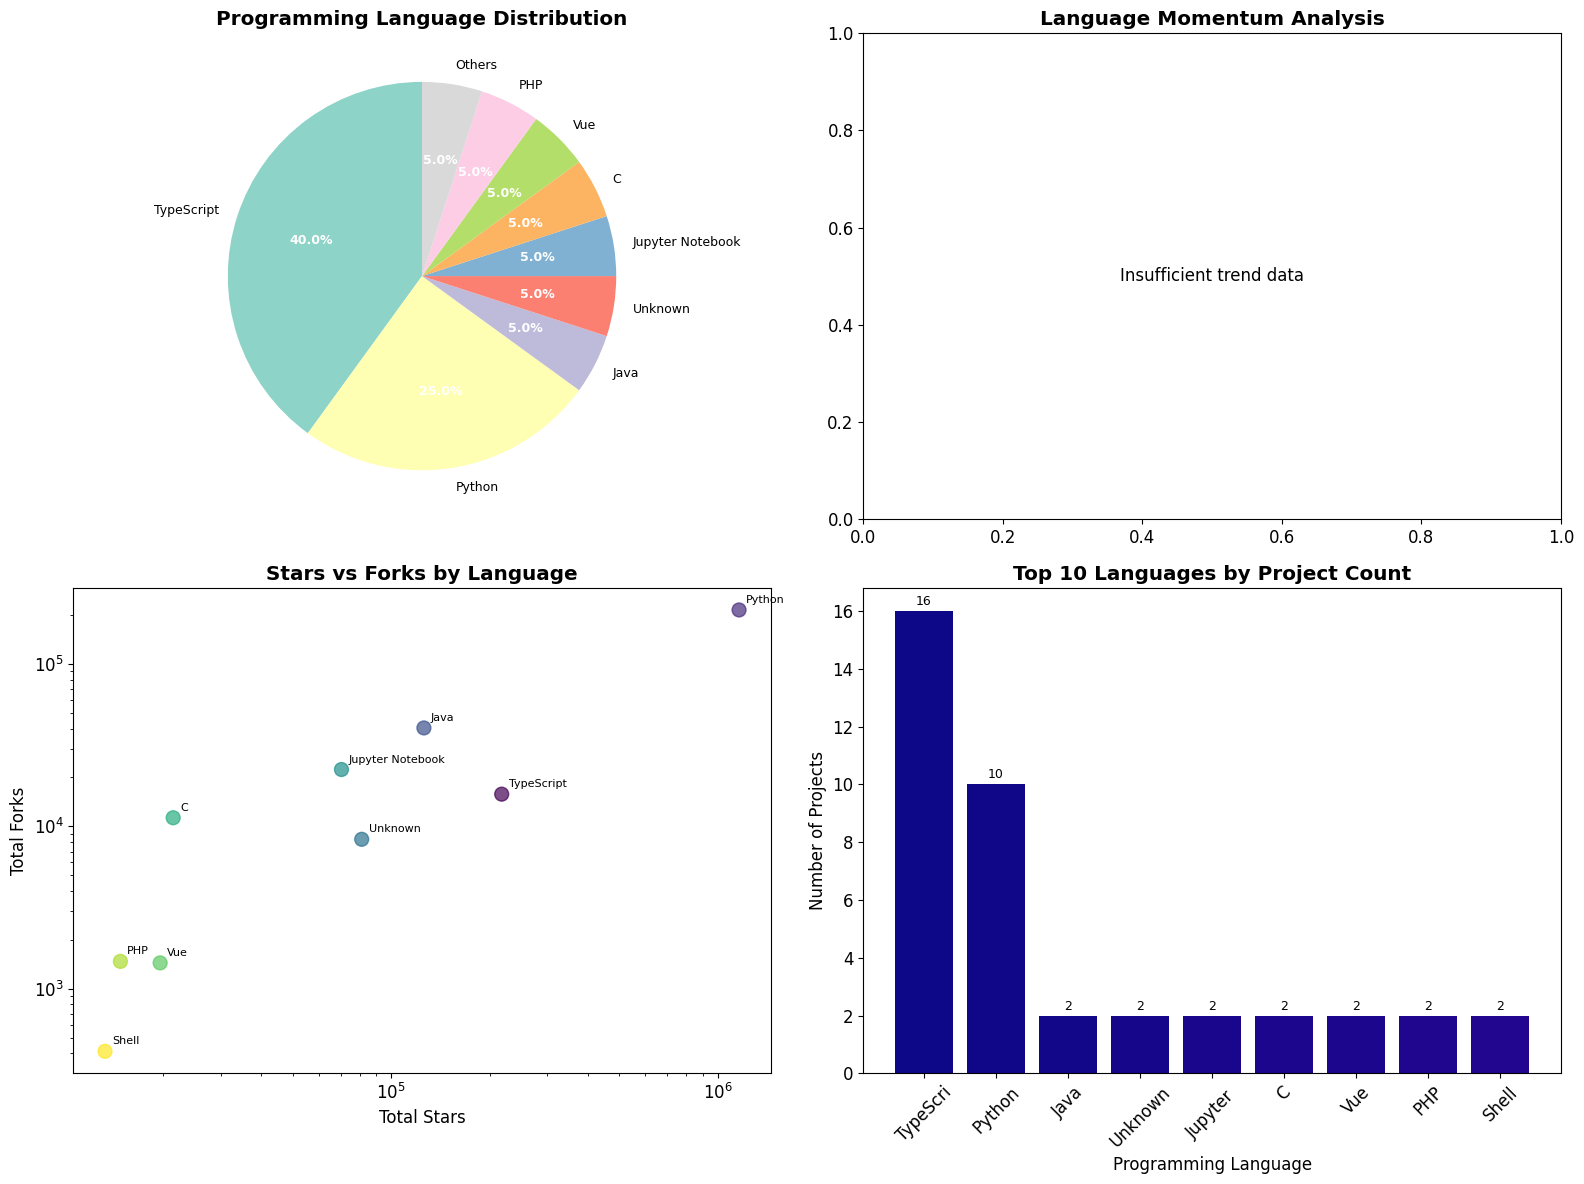

Enhanced visualizations created and saved as 'enhanced_github_analysis.png'
Enhanced comprehensive report generated successfully


In [41]:
# Collect today's trending data and perform comprehensive analysis
data, lang_stats, top_stars, top_forks = analyze_github_trending_enhanced(days=14)

Generating enhanced comprehensive analysis report...
Loaded 40 records from database
ENHANCED GITHUB TRENDING ANALYSIS REPORT
Analysis Period: 14 days
Total Records: 40
Unique Projects: 20
Report Generated: 2025-08-25 17:05:27

🌟 TOP 10 REPOSITORIES BY STARS
--------------------------------------------------------------------------------
 1. EbookFoundation/free-programming-books         ⭐366,225 🍴63,967 [Python]
 2. yt-dlp/yt-dlp                         ⭐123,832 🍴 9,875 [Python]
 3. django/django                         ⭐ 84,752 🍴32,853 [Python]
 4. TheAlgorithms/Java                           ⭐ 62,938 🍴20,183 [Java]
 5. GitHubDaily/GitHubDaily                    ⭐ 40,604 🍴 4,163 [Unknown]
 6. microsoft/ai-agents-for-beginners        ⭐ 35,186 🍴11,195 [Jupyter Notebook]
 7. RSSNext/Folo                           ⭐ 32,304 🍴 1,496 [TypeScript]
 8. Budibase/budibase                       ⭐ 26,344 🍴 1,895 [TypeScript]
 9. simstudioai/sim                            ⭐ 12,016 🍴 1,395 [TypeScr

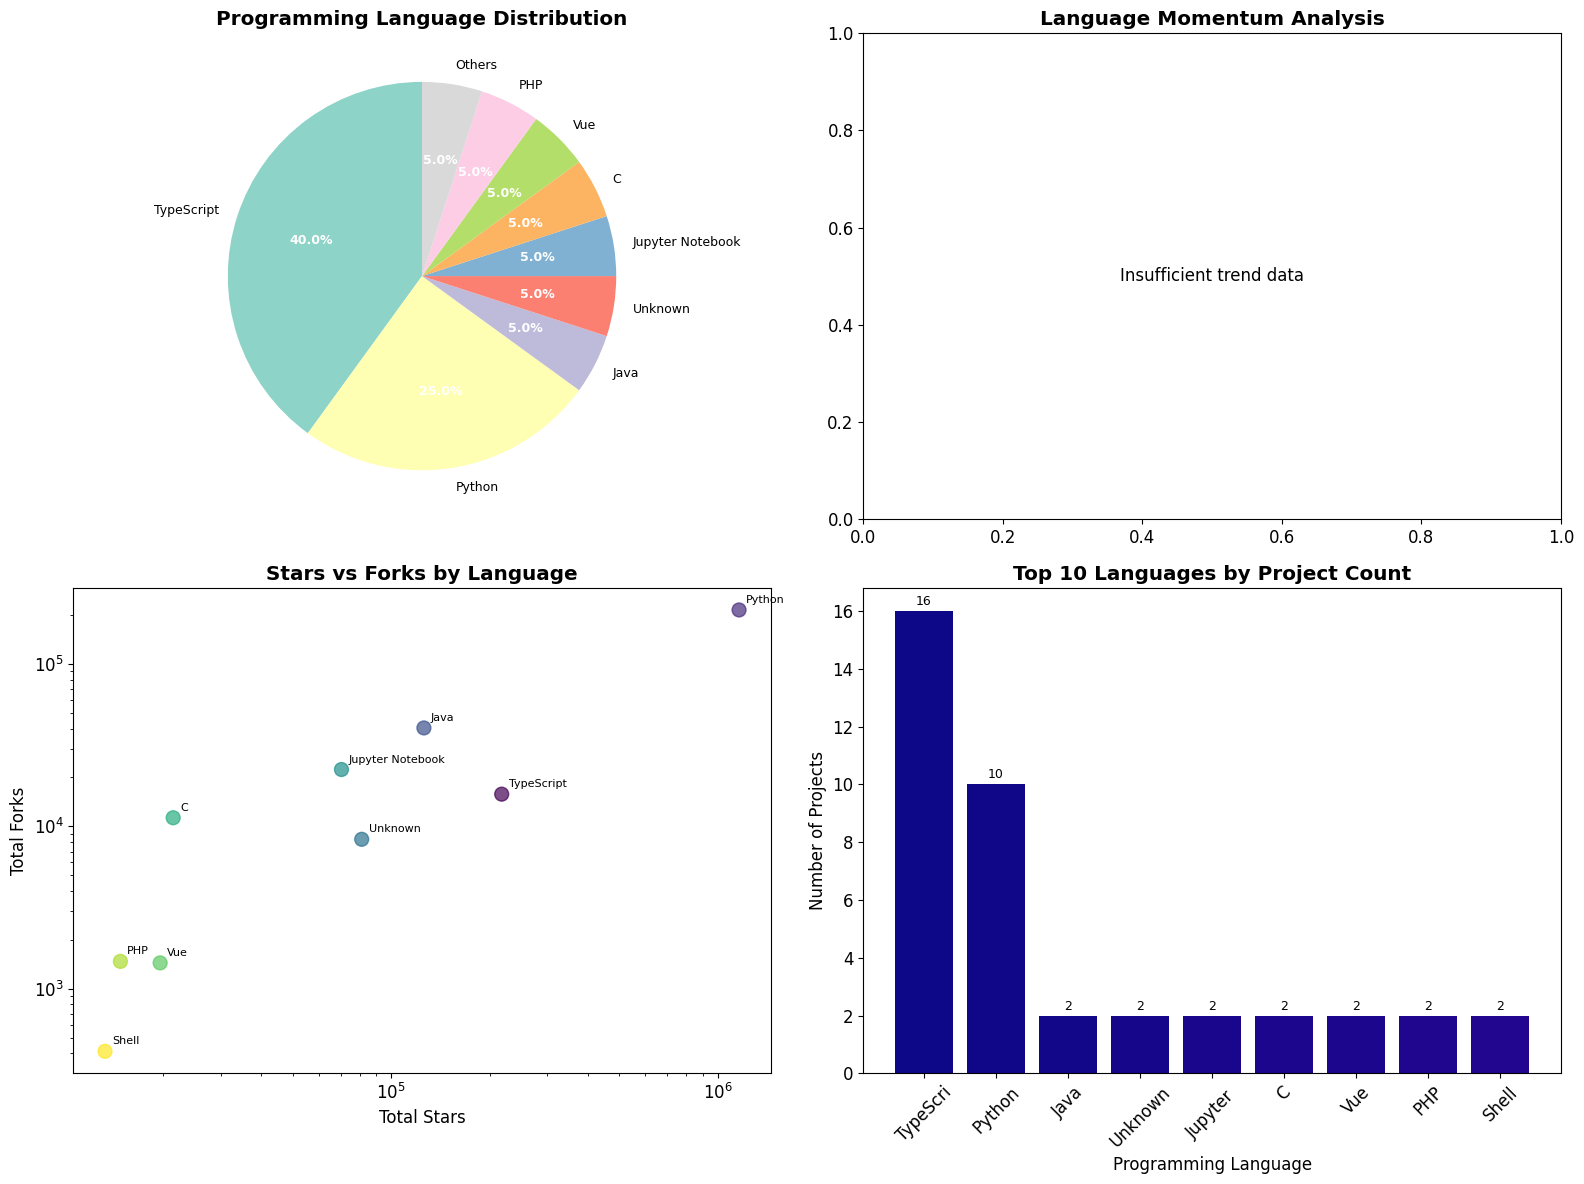

Enhanced visualizations created and saved as 'enhanced_github_analysis.png'
Enhanced comprehensive report generated successfully


In [42]:
# Analyze previously collected data without new crawling
data, lang_stats, top_stars, top_forks = analyze_existing_data_enhanced(days=14)

Starting extended data collection for 14 days
Enhanced database initialized successfully
Starting enhanced 14-day data collection
Crawling GitHub trending: https://github.com/trending?since=daily
Successfully extracted 20 repositories
Successfully saved 20 repositories to database
  └─ Collected 20 repos with 6763 total daily stars
  └─ Waiting 112 seconds before next request
Crawling GitHub trending: https://github.com/trending?since=daily
Successfully extracted 20 repositories
Successfully saved 20 repositories to database
  └─ Collected 20 repos with 6763 total daily stars
  └─ Waiting 89 seconds before next request
Crawling GitHub trending: https://github.com/trending?since=daily
Successfully extracted 20 repositories
Successfully saved 20 repositories to database
  └─ Collected 20 repos with 6763 total daily stars
  └─ Waiting 124 seconds before next request
Crawling GitHub trending: https://github.com/trending?since=daily
Successfully extracted 20 repositories
Successfully saved 

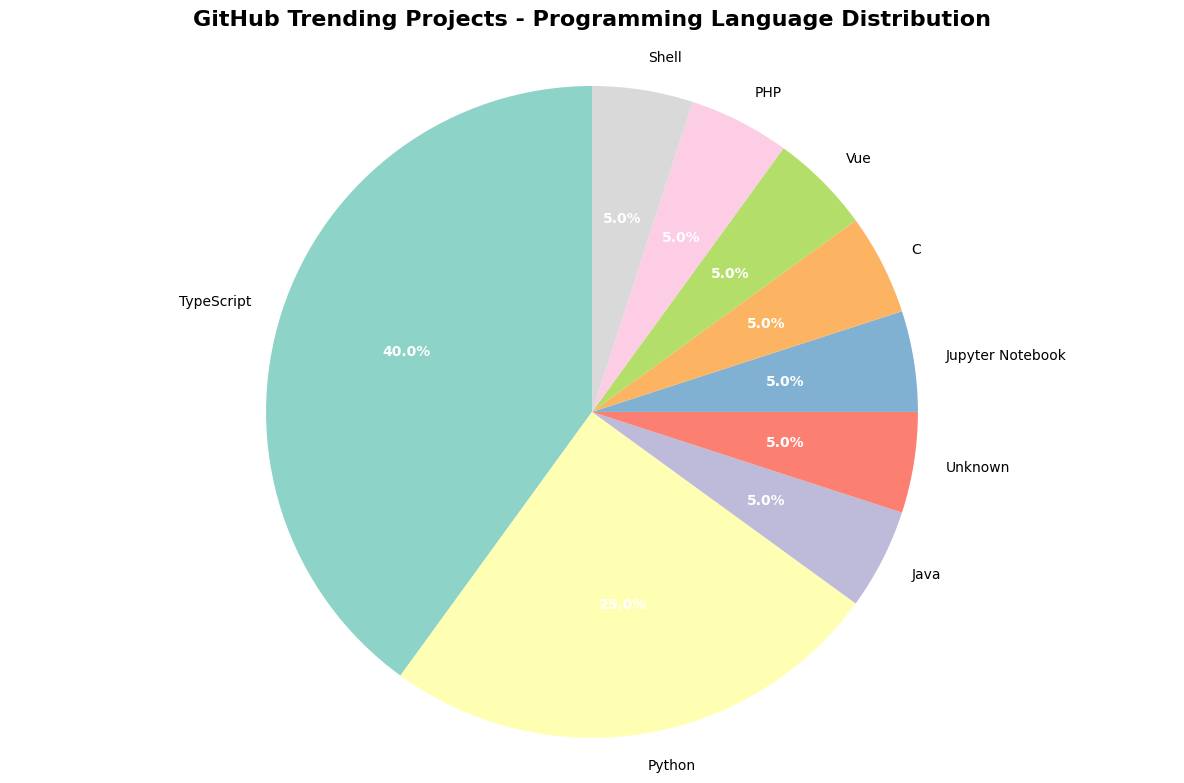

Language distribution chart saved to: language_distribution.png
Comprehensive report generated successfully


In [43]:
# Collect data over multiple days (recommended for comprehensive analysis)
data, lang_stats, top_stars, top_forks = collect_extended_data(days=14)

In [52]:
import csv
import json
from datetime import datetime

def export_to_csv_fixed(data, filename):
    """Export data list to CSV file."""
    if not data:
        print(f"No data to export to {filename}")
        return
    
    # Get all possible field names from the data
    fieldnames = set()
    for row in data:
        if isinstance(row, dict):
            fieldnames.update(row.keys())
    
    fieldnames = sorted(list(fieldnames))
    
    with open(filename, 'w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        
        for row in data:
            if isinstance(row, dict):
                # Fill missing fields with empty string
                complete_row = {field: row.get(field, '') for field in fieldnames}
                writer.writerow(complete_row)
    
    print(f"✅ Exported {len(data)} records to {filename}")

def export_to_json_fixed(data, filename):
    """Export data list to JSON file."""
    if not data:
        print(f"No data to export to {filename}")
        return
    
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=2, default=str)
    
    print(f"✅ Exported {len(data)} records to {filename}")

def export_your_analysis_now():
    """
    Export your current analysis data - FIXED VERSION
    This works with your existing DataFrameReplacement objects.
    """
    print("🚀 EXPORTING YOUR GITHUB TRENDING ANALYSIS")
    print("=" * 60)
    
    try:
        # Get your analyzer and data
        analyzer = EnhancedGitHubAnalyzer()
        df = analyzer.load_data(days=30)  # Get all your data
        
        if df.empty:
            print("❌ No data available in database")
            return
        
        # Generate analysis components
        top_by_stars = analyzer.get_top_repositories(df, 'total_stars', 20)
        top_by_forks = analyzer.get_top_repositories(df, 'total_forks', 20)
        language_stats = analyzer.analyze_programming_languages(df)
        
        print(f"📊 Exporting analysis from {len(df)} records...")
        print(f"🎯 Date range: {min(row['crawl_date'] for row in df.data)} to {max(row['crawl_date'] for row in df.data)}")
        print()
        
        # Export all data using our FIXED functions
        export_to_csv_fixed(df.data, 'github_trending_complete_data.csv')
        export_to_csv_fixed(language_stats.data, 'programming_language_analysis.csv')
        export_to_csv_fixed(top_by_stars.data, 'top_20_repositories_by_stars.csv')
        export_to_csv_fixed(top_by_forks.data, 'top_20_repositories_by_forks.csv')
        
        # Export to JSON as well
        export_to_json_fixed(df.data, 'github_trending_complete_data.json')
        export_to_json_fixed(language_stats.data, 'programming_language_analysis.json')
        export_to_json_fixed(top_by_stars.data, 'top_20_repositories_by_stars.json')
        export_to_json_fixed(top_by_forks.data, 'top_20_repositories_by_forks.json')
        
        # Create a detailed summary based on your actual data
        summary = {
            'export_timestamp': str(datetime.now()),
            'analysis_summary': {
                'total_records': len(df),
                'unique_projects': len(set((row['author'], row['repo_name']) for row in df.data)),
                'total_stars_tracked': sum(row['total_stars'] for row in df.data),
                'total_forks_tracked': sum(row['total_forks'] for row in df.data),
                'total_daily_stars': sum(row['today_stars'] for row in df.data),
                'projects_with_daily_growth': len([row for row in df.data if row['today_stars'] > 0])
            },
            'top_languages': [
                {
                    'language': row['language'], 
                    'project_count': row['project_count'],
                    'total_stars': row['total_stars'],
                    'percentage': round((row['project_count'] / len(df)) * 100, 1)
                } 
                for row in language_stats.data[:10]
            ],
            'top_repositories': [
                {
                    'rank': i+1,
                    'full_name': f"{row['author']}/{row['repo_name']}",
                    'language': row['language'],
                    'stars': row['total_stars'],
                    'forks': row['total_forks']
                }
                for i, row in enumerate(top_by_stars.data[:10])
            ],
            'insights': {
                'most_popular_language': language_stats.data[0]['language'] if language_stats.data else 'Unknown',
                'highest_starred_repo': f"{top_by_stars.data[0]['author']}/{top_by_stars.data[0]['repo_name']}" if top_by_stars.data else 'Unknown',
                'average_stars_per_project': round(sum(row['total_stars'] for row in df.data) / len(df.data)),
                'typescript_dominance': f"{round((language_stats.data[0]['project_count'] / len(df)) * 100, 1)}%" if language_stats.data else "0%"
            }
        }
        
        export_to_json_fixed([summary], 'github_trending_analysis_summary.json')
        
        print("\n" + "=" * 60)
        print("🎉 EXPORT COMPLETED SUCCESSFULLY!")
        print("=" * 60)
        print("📁 Files created:")
        print("  📊 CSV Files (for Excel/Google Sheets):")
        print("    • github_trending_complete_data.csv")
        print("    • programming_language_analysis.csv")
        print("    • top_20_repositories_by_stars.csv")
        print("    • top_20_repositories_by_forks.csv")
        print()
        print("  🔗 JSON Files (for programming):")
        print("    • github_trending_complete_data.json")
        print("    • programming_language_analysis.json")
        print("    • top_20_repositories_by_stars.json")
        print("    • top_20_repositories_by_forks.json")
        print()
        print("  📋 Summary:")
        print("    • github_trending_analysis_summary.json")
        print()
        print("💡 Your Analysis Highlights:")
        print(f"  • {len(df)} repositories analyzed")
        print(f"  • {language_stats.data[0]['language']} is the dominant language ({language_stats.data[0]['project_count']} projects)")
        print(f"  • Top repo: {top_by_stars.data[0]['author']}/{top_by_stars.data[0]['repo_name']} ({top_by_stars.data[0]['total_stars']:,} stars)")
        print(f"  • Total stars tracked: {sum(row['total_stars'] for row in df.data):,}")
        print(f"  • Active projects today: {len([row for row in df.data if row['today_stars'] > 0])}")
        
        return True
        
    except Exception as e:
        print(f"❌ Export failed: {e}")
        import traceback
        traceback.print_exc()
        return False

# Override the problematic export function
def export_analysis_results():
    """Fixed version of export_analysis_results"""
    return export_your_analysis_now()

In [51]:
export_analysis_results()

🚀 EXPORTING YOUR GITHUB TRENDING ANALYSIS
Loaded 40 records from database
📊 Exporting analysis from 40 records...
🎯 Date range: 2025-08-19 to 2025-08-25

✅ Exported 40 records to github_trending_complete_data.csv
✅ Exported 9 records to programming_language_analysis.csv
✅ Exported 20 records to top_20_repositories_by_stars.csv
✅ Exported 20 records to top_20_repositories_by_forks.csv
✅ Exported 40 records to github_trending_complete_data.json
✅ Exported 9 records to programming_language_analysis.json
✅ Exported 20 records to top_20_repositories_by_stars.json
✅ Exported 20 records to top_20_repositories_by_forks.json
✅ Exported 1 records to github_trending_analysis_summary.json

🎉 EXPORT COMPLETED SUCCESSFULLY!
📁 Files created:
  📊 CSV Files (for Excel/Google Sheets):
    • github_trending_complete_data.csv
    • programming_language_analysis.csv
    • top_20_repositories_by_stars.csv
    • top_20_repositories_by_forks.csv

  🔗 JSON Files (for programming):
    • github_trending_complet

True

In [53]:
import matplotlib.pyplot as plt
import json
from datetime import datetime, timedelta
from collections import Counter
import sqlite3

# === Language-Specific Deep Dive Analysis ===

def analyze_language_trends(language_name, days=30):

    analyzer = GitHubTrendingAnalyzer()
    df = analyzer.load_data(days)
    
    if df.empty:
        print(f"No data available for analysis")
        return None
    
    # Filter for specific language
    language_projects = [
        row for row in df.data 
        if row['language'].lower() == language_name.lower()
    ]
    
    if not language_projects:
        print(f"No {language_name} projects found in the data")
        return None
    
    # Calculate metrics
    total_projects = len(language_projects)
    total_stars = sum(p['total_stars'] for p in language_projects)
    total_forks = sum(p['total_forks'] for p in language_projects)
    avg_stars = total_stars / total_projects
    avg_forks = total_forks / total_projects
    
    # Find top projects
    top_by_stars = sorted(language_projects, key=lambda x: x['total_stars'], reverse=True)[:10]
    top_by_engagement = sorted(
        language_projects, 
        key=lambda x: x['total_forks'] / max(x['total_stars'], 1), 
        reverse=True
    )[:10]
    
    # Analyze growth patterns
    recent_projects = [p for p in language_projects if p['today_stars'] > 0]
    growth_rate = len(recent_projects) / total_projects * 100
    
    # Print detailed report
    print("=" * 80)
    print(f"{language_name.upper()} PROGRAMMING LANGUAGE DEEP DIVE")
    print("=" * 80)
    print(f"Analysis Period: {days} days")
    print(f"Total {language_name} Projects: {total_projects}")
    print(f"Total Stars: {total_stars:,}")
    print(f"Total Forks: {total_forks:,}")
    print(f"Average Stars per Project: {avg_stars:.1f}")
    print(f"Average Forks per Project: {avg_forks:.1f}")
    print(f"Active Growth Rate: {growth_rate:.1f}% of projects gained stars recently")
    print()
    
    print(f"TOP 10 {language_name.upper()} PROJECTS BY STARS:")
    print("-" * 60)
    for i, project in enumerate(top_by_stars, 1):
        print(f"{i:2d}. {project['author']}/{project['repo_name']:<25} "
              f"⭐{project['total_stars']:>6,} 🍴{project['total_forks']:>5,}")
    print()
    
    print(f"TOP 10 {language_name.upper()} PROJECTS BY COMMUNITY ENGAGEMENT:")
    print("-" * 60)
    for i, project in enumerate(top_by_engagement, 1):
        engagement = project['total_forks'] / max(project['total_stars'], 1)
        print(f"{i:2d}. {project['author']}/{project['repo_name']:<25} "
              f"Ratio: {engagement:.3f}")
    print()
    
    return {
        'language': language_name,
        'total_projects': total_projects,
        'metrics': {
            'total_stars': total_stars,
            'total_forks': total_forks,
            'avg_stars': avg_stars,
            'avg_forks': avg_forks,
            'growth_rate': growth_rate
        },
        'top_projects': top_by_stars,
        'high_engagement': top_by_engagement
    }

# === Time Series Analysis ===

def analyze_trending_timeline(days=14):

    with sqlite3.connect('github_trending.db') as conn:
        cursor = conn.cursor()
        
        # Get data grouped by date
        query = '''
            SELECT crawl_date, 
                   COUNT(*) as project_count,
                   AVG(total_stars) as avg_stars,
                   AVG(total_forks) as avg_forks,
                   SUM(today_stars) as daily_new_stars,
                   COUNT(DISTINCT language) as unique_languages
            FROM trending_repos 
            WHERE crawl_date >= date('now', '-{} days')
            GROUP BY crawl_date
            ORDER BY crawl_date
        '''.format(days)
        
        cursor.execute(query)
        results = cursor.fetchall()
    
    if not results:
        print("No timeline data available")
        return None
    
    # Process timeline data
    dates = [row[0] for row in results]
    project_counts = [row[1] for row in results]
    avg_stars = [row[2] for row in results]
    avg_forks = [row[3] for row in results]
    daily_new_stars = [row[4] or 0 for row in results]
    unique_languages = [row[5] for row in results]
    
    print("=" * 80)
    print("GITHUB TRENDING TIMELINE ANALYSIS")
    print("=" * 80)
    
    print("DAILY METRICS:")
    print("-" * 50)
    for i, date in enumerate(dates):
        print(f"{date}: {project_counts[i]} projects, "
              f"Avg Stars: {avg_stars[i]:.0f}, "
              f"New Stars: {daily_new_stars[i]}")
    
    # Create visualization if matplotlib available
    if MATPLOTLIB_AVAILABLE:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # Project count over time
        ax1.plot(dates, project_counts, marker='o', linewidth=2)
        ax1.set_title('Daily Project Count')
        ax1.set_ylabel('Number of Projects')
        ax1.tick_params(axis='x', rotation=45)
        
        # Average stars over time
        ax2.plot(dates, avg_stars, marker='s', color='orange', linewidth=2)
        ax2.set_title('Average Stars Over Time')
        ax2.set_ylabel('Average Stars')
        ax2.tick_params(axis='x', rotation=45)
        
        # Daily new stars
        ax3.bar(dates, daily_new_stars, color='green', alpha=0.7)
        ax3.set_title('Daily New Stars Activity')
        ax3.set_ylabel('Total New Stars')
        ax3.tick_params(axis='x', rotation=45)
        
        # Language diversity
        ax4.plot(dates, unique_languages, marker='^', color='purple', linewidth=2)
        ax4.set_title('Language Diversity Over Time')
        ax4.set_ylabel('Unique Languages')
        ax4.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        print("Timeline visualization created")
    
    return {
        'dates': dates,
        'metrics': {
            'project_counts': project_counts,
            'avg_stars': avg_stars,
            'avg_forks': avg_forks,
            'daily_new_stars': daily_new_stars,
            'unique_languages': unique_languages
        }
    }

# === Repository Category Analysis ===

def analyze_by_categories(days=14):

    analyzer = GitHubTrendingAnalyzer()
    df = analyzer.load_data(days)
    
    if df.empty:
        return None
    
    # Define categories by star count
    categories = {
        'Mega Projects': {'min': 50000, 'max': float('inf')},
        'Large Projects': {'min': 10000, 'max': 49999},
        'Medium Projects': {'min': 1000, 'max': 9999},
        'Small Projects': {'min': 100, 'max': 999},
        'New Projects': {'min': 0, 'max': 99}
    }
    
    category_analysis = {}
    
    for category_name, criteria in categories.items():
        category_projects = [
            row for row in df.data 
            if criteria['min'] <= row['total_stars'] <= criteria['max']
        ]
        
        if category_projects:
            languages = Counter(p['language'] for p in category_projects)
            avg_forks = sum(p['total_forks'] for p in category_projects) / len(category_projects)
            avg_today_stars = sum(p['today_stars'] for p in category_projects) / len(category_projects)
            
            category_analysis[category_name] = {
                'count': len(category_projects),
                'top_languages': languages.most_common(3),
                'avg_forks': avg_forks,
                'avg_today_stars': avg_today_stars,
                'sample_projects': category_projects[:3]
            }
    
    # Print analysis
    print("=" * 80)
    print("REPOSITORY CATEGORY ANALYSIS")
    print("=" * 80)
    
    for category, data in category_analysis.items():
        print(f"\n{category.upper()}")
        print("-" * 40)
        print(f"Count: {data['count']} projects")
        print(f"Average Forks: {data['avg_forks']:.1f}")
        print(f"Average Daily New Stars: {data['avg_today_stars']:.1f}")
        print(f"Top Languages: {', '.join([f'{lang}({count})' for lang, count in data['top_languages']])}")
        
        if data['sample_projects']:
            print("Sample Projects:")
            for proj in data['sample_projects']:
                print(f"  • {proj['author']}/{proj['repo_name']} - ⭐{proj['total_stars']:,}")
    
    return category_analysis

# === Competitive Analysis ===

def compare_languages(lang1, lang2, days=30):
    
    analyzer = GitHubTrendingAnalyzer()
    df = analyzer.load_data(days)
    
    if df.empty:
        return None
    
    # Get projects for each language
    lang1_projects = [r for r in df.data if r['language'].lower() == lang1.lower()]
    lang2_projects = [r for r in df.data if r['language'].lower() == lang2.lower()]
    
    if not lang1_projects or not lang2_projects:
        print("Insufficient data for comparison")
        return None
    
    # Calculate metrics for both languages
    def calculate_metrics(projects):
        return {
            'count': len(projects),
            'total_stars': sum(p['total_stars'] for p in projects),
            'total_forks': sum(p['total_forks'] for p in projects),
            'avg_stars': sum(p['total_stars'] for p in projects) / len(projects),
            'avg_forks': sum(p['total_forks'] for p in projects) / len(projects),
            'active_projects': len([p for p in projects if p['today_stars'] > 0]),
            'top_project': max(projects, key=lambda x: x['total_stars'])
        }
    
    lang1_metrics = calculate_metrics(lang1_projects)
    lang2_metrics = calculate_metrics(lang2_projects)
    
    # Print comparison
    print("=" * 80)
    print(f"{lang1.upper()} vs {lang2.upper()} - COMPETITIVE ANALYSIS")
    print("=" * 80)
    
    print(f"{'Metric':<25} {lang1.upper():<20} {lang2.upper():<20} {'Winner':<15}")
    print("-" * 80)
    
    metrics_to_compare = [
        ('Project Count', 'count'),
        ('Total Stars', 'total_stars'),
        ('Total Forks', 'total_forks'),
        ('Avg Stars', 'avg_stars'),
        ('Avg Forks', 'avg_forks'),
        ('Active Projects', 'active_projects')
    ]
    
    winners = {lang1: 0, lang2: 0}
    
    for metric_name, metric_key in metrics_to_compare:
        val1 = lang1_metrics[metric_key]
        val2 = lang2_metrics[metric_key]
        
        if isinstance(val1, float):
            val1_str = f"{val1:.1f}"
            val2_str = f"{val2:.1f}"
        else:
            val1_str = f"{val1:,}"
            val2_str = f"{val2:,}"
        
        winner = lang1 if val1 > val2 else lang2
        winners[winner] += 1
        
        print(f"{metric_name:<25} {val1_str:<20} {val2_str:<20} {winner.upper():<15}")
    
    print("\n" + "=" * 80)
    overall_winner = max(winners.items(), key=lambda x: x[1])
    print(f"OVERALL WINNER: {overall_winner[0].upper()} ({overall_winner[1]}/6 metrics)")
    
    print(f"\nTop {lang1} Project: {lang1_metrics['top_project']['author']}/{lang1_metrics['top_project']['repo_name']}")
    print(f"Top {lang2} Project: {lang2_metrics['top_project']['author']}/{lang2_metrics['top_project']['repo_name']}")
    
    return {
        'lang1': lang1,
        'lang2': lang2,
        'lang1_metrics': lang1_metrics,
        'lang2_metrics': lang2_metrics,
        'winner': overall_winner[0]
    }

# === Trend Prediction Analysis ===

def predict_trending_patterns(days=30):

    with sqlite3.connect('github_trending.db') as conn:
        cursor = conn.cursor()
        
        # Get language trend data
        query = '''
            SELECT language, crawl_date, COUNT(*) as daily_count
            FROM trending_repos 
            WHERE crawl_date >= date('now', '-{} days')
            GROUP BY language, crawl_date
            ORDER BY language, crawl_date
        '''.format(days)
        
        cursor.execute(query)
        results = cursor.fetchall()
    
    if not results:
        return None
    
    # Analyze language momentum
    language_trends = {}
    for lang, date, count in results:
        if lang not in language_trends:
            language_trends[lang] = []
        language_trends[lang].append((date, count))
    
    # Calculate trend momentum for each language
    momentum_analysis = {}
    for lang, data_points in language_trends.items():
        if len(data_points) >= 3:  # Need at least 3 data points
            recent_avg = sum(point[1] for point in data_points[-7:]) / min(7, len(data_points[-7:]))
            early_avg = sum(point[1] for point in data_points[:7]) / min(7, len(data_points[:7]))
            
            momentum = (recent_avg - early_avg) / max(early_avg, 1) * 100
            
            momentum_analysis[lang] = {
                'momentum_percent': momentum,
                'recent_avg': recent_avg,
                'early_avg': early_avg,
                'data_points': len(data_points)
            }
    
    # Sort by momentum
    rising_languages = sorted(
        [(lang, data) for lang, data in momentum_analysis.items() if data['momentum_percent'] > 10],
        key=lambda x: x[1]['momentum_percent'],
        reverse=True
    )
    
    declining_languages = sorted(
        [(lang, data) for lang, data in momentum_analysis.items() if data['momentum_percent'] < -10],
        key=lambda x: x[1]['momentum_percent']
    )
    
    print("=" * 80)
    print("TRENDING PATTERN PREDICTION ANALYSIS")
    print("=" * 80)
    
    print("\n🚀 RISING LANGUAGES (Strong Upward Momentum):")
    print("-" * 50)
    for lang, data in rising_languages[:5]:
        print(f"{lang:<20} +{data['momentum_percent']:>6.1f}% momentum")
    
    print("\n📉 DECLINING LANGUAGES (Downward Momentum):")
    print("-" * 50)
    for lang, data in declining_languages[:5]:
        print(f"{lang:<20} {data['momentum_percent']:>7.1f}% momentum")
    
    # Predict next week's top languages
    stable_languages = [
        (lang, data) for lang, data in momentum_analysis.items() 
        if -10 <= data['momentum_percent'] <= 10 and data['recent_avg'] > 5
    ]
    
    print("\n⚖️ STABLE HIGH-VOLUME LANGUAGES:")
    print("-" * 50)
    stable_sorted = sorted(stable_languages, key=lambda x: x[1]['recent_avg'], reverse=True)
    for lang, data in stable_sorted[:5]:
        print(f"{lang:<20} {data['recent_avg']:>6.1f} avg daily projects")
    
    return {
        'rising_languages': rising_languages,
        'declining_languages': declining_languages,
        'stable_languages': stable_languages,
        'momentum_analysis': momentum_analysis
    }

# === Custom Dashboard Function ===

def create_custom_dashboard(languages=None, min_stars=0, days=14):

    analyzer = GitHubTrendingAnalyzer()
    df = analyzer.load_data(days)
    
    if df.empty:
        return None
    
    # Apply filters
    filtered_projects = []
    for row in df.data:
        if languages and row['language'] not in languages:
            continue
        if row['total_stars'] < min_stars:
            continue
        filtered_projects.append(row)
    
    if not filtered_projects:
        print("No projects match the specified criteria")
        return None
    
    # Calculate dashboard metrics
    total_projects = len(filtered_projects)
    total_stars = sum(p['total_stars'] for p in filtered_projects)
    total_forks = sum(p['total_forks'] for p in filtered_projects)
    
    # Language distribution
    lang_dist = Counter(p['language'] for p in filtered_projects)
    
    # Top performers
    top_stars = sorted(filtered_projects, key=lambda x: x['total_stars'], reverse=True)[:10]
    top_growth = sorted(filtered_projects, key=lambda x: x['today_stars'], reverse=True)[:10]
    
    # Recent activity
    active_projects = [p for p in filtered_projects if p['today_stars'] > 0]
    
    print("=" * 80)
    print("CUSTOM DASHBOARD")
    print("=" * 80)
    print(f"Filters Applied:")
    if languages:
        print(f"  • Languages: {', '.join(languages)}")
    if min_stars > 0:
        print(f"  • Minimum Stars: {min_stars:,}")
    print(f"  • Analysis Period: {days} days")
    print()
    
    print(f"OVERVIEW METRICS:")
    print(f"  • Total Projects: {total_projects:,}")
    print(f"  • Total Stars: {total_stars:,}")
    print(f"  • Total Forks: {total_forks:,}")
    print(f"  • Active Projects Today: {len(active_projects)} ({len(active_projects)/total_projects*100:.1f}%)")
    print()
    
    print("LANGUAGE DISTRIBUTION:")
    for lang, count in lang_dist.most_common(5):
        percentage = count / total_projects * 100
        print(f"  • {lang}: {count} projects ({percentage:.1f}%)")
    print()
    
    print("TOP PERFORMERS BY STARS:")
    for i, proj in enumerate(top_stars[:5], 1):
        print(f"  {i}. {proj['author']}/{proj['repo_name']} - ⭐{proj['total_stars']:,}")
    print()
    
    print("HIGHEST GROWTH TODAY:")
    for i, proj in enumerate(top_growth[:5], 1):
        if proj['today_stars'] > 0:
            print(f"  {i}. {proj['author']}/{proj['repo_name']} - +{proj['today_stars']:,} stars today")
    
    return {
        'total_projects': total_projects,
        'metrics': {
            'total_stars': total_stars,
            'total_forks': total_forks,
            'active_projects': len(active_projects)
        },
        'language_distribution': dict(lang_dist),
        'top_performers': top_stars,
        'high_growth': top_growth
    }

print("Available Advanced Functions:")
print("1. analyze_language_trends(language, days=30)")
print("   - Deep dive into specific language trends")
print("   - Example: analyze_language_trends('Python', days=30)")
print()
print("2. analyze_trending_timeline(days=14)")
print("   - Time series analysis with visualizations")
print("   - Shows daily metrics and trends over time")
print()
print("3. analyze_by_categories(days=14)")
print("   - Categorize projects by size and analyze patterns")
print("   - Groups projects by star count ranges")
print()
print("4. compare_languages(lang1, lang2, days=30)")
print("   - Head-to-head language comparison")
print("   - Example: compare_languages('Python', 'JavaScript', days=30)")
print()
print("5. predict_trending_patterns(days=30)")
print("   - Analyze momentum and predict future trends")
print("   - Identifies rising and declining languages")
print()
print("6. create_custom_dashboard(languages, min_stars, days)")
print("   - Custom filtered analysis dashboard")
print("   - Example: create_custom_dashboard(['Python', 'Go'], min_stars=1000, days=14)")

Available Advanced Functions:
1. analyze_language_trends(language, days=30)
   - Deep dive into specific language trends
   - Example: analyze_language_trends('Python', days=30)

2. analyze_trending_timeline(days=14)
   - Time series analysis with visualizations
   - Shows daily metrics and trends over time

3. analyze_by_categories(days=14)
   - Categorize projects by size and analyze patterns
   - Groups projects by star count ranges

4. compare_languages(lang1, lang2, days=30)
   - Head-to-head language comparison
   - Example: compare_languages('Python', 'JavaScript', days=30)

5. predict_trending_patterns(days=30)
   - Analyze momentum and predict future trends
   - Identifies rising and declining languages

6. create_custom_dashboard(languages, min_stars, days)
   - Custom filtered analysis dashboard
   - Example: create_custom_dashboard(['Python', 'Go'], min_stars=1000, days=14)


In [64]:
python_analysis = analyze_language_trends('Python', days=14)

Loaded 40 records from database
PYTHON PROGRAMMING LANGUAGE DEEP DIVE
Analysis Period: 14 days
Total Python Projects: 10
Total Stars: 1,163,474
Total Forks: 215,028
Average Stars per Project: 116347.4
Average Forks per Project: 21502.8
Active Growth Rate: 50.0% of projects gained stars recently

TOP 10 PYTHON PROJECTS BY STARS:
------------------------------------------------------------
 1. EbookFoundation/free-programming-books    ⭐366,229 🍴63,967
 2. EbookFoundation/free-programming-books    ⭐366,184 🍴63,965
 3. yt-dlp/yt-dlp                    ⭐123,837 🍴9,875
 4. yt-dlp/yt-dlp                    ⭐123,797 🍴9,872
 5. django/django                    ⭐84,753 🍴32,854
 6. django/django                    ⭐84,742 🍴32,854
 7. HunxByts/GhostTrack                ⭐ 4,361 🍴  517
 8. HunxByts/GhostTrack                ⭐ 4,292 🍴  513
 9. HKUDS/DeepCode                  ⭐ 2,685 🍴  308
10. HKUDS/DeepCode                  ⭐ 2,594 🍴  303

TOP 10 PYTHON PROJECTS BY COMMUNITY ENGAGEMENT:
------------

2025-08-25 17:36:05,913 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-08-25 17:36:05,914 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-08-25 17:36:05,915 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-08-25 17:36:05,917 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-08-25 17:36:05,

GITHUB TRENDING TIMELINE ANALYSIS
DAILY METRICS:
--------------------------------------------------
2025-08-19: 20 projects, Avg Stars: 43161, New Stars: 0
2025-08-25: 20 projects, Avg Stars: 43233, New Stars: 6763


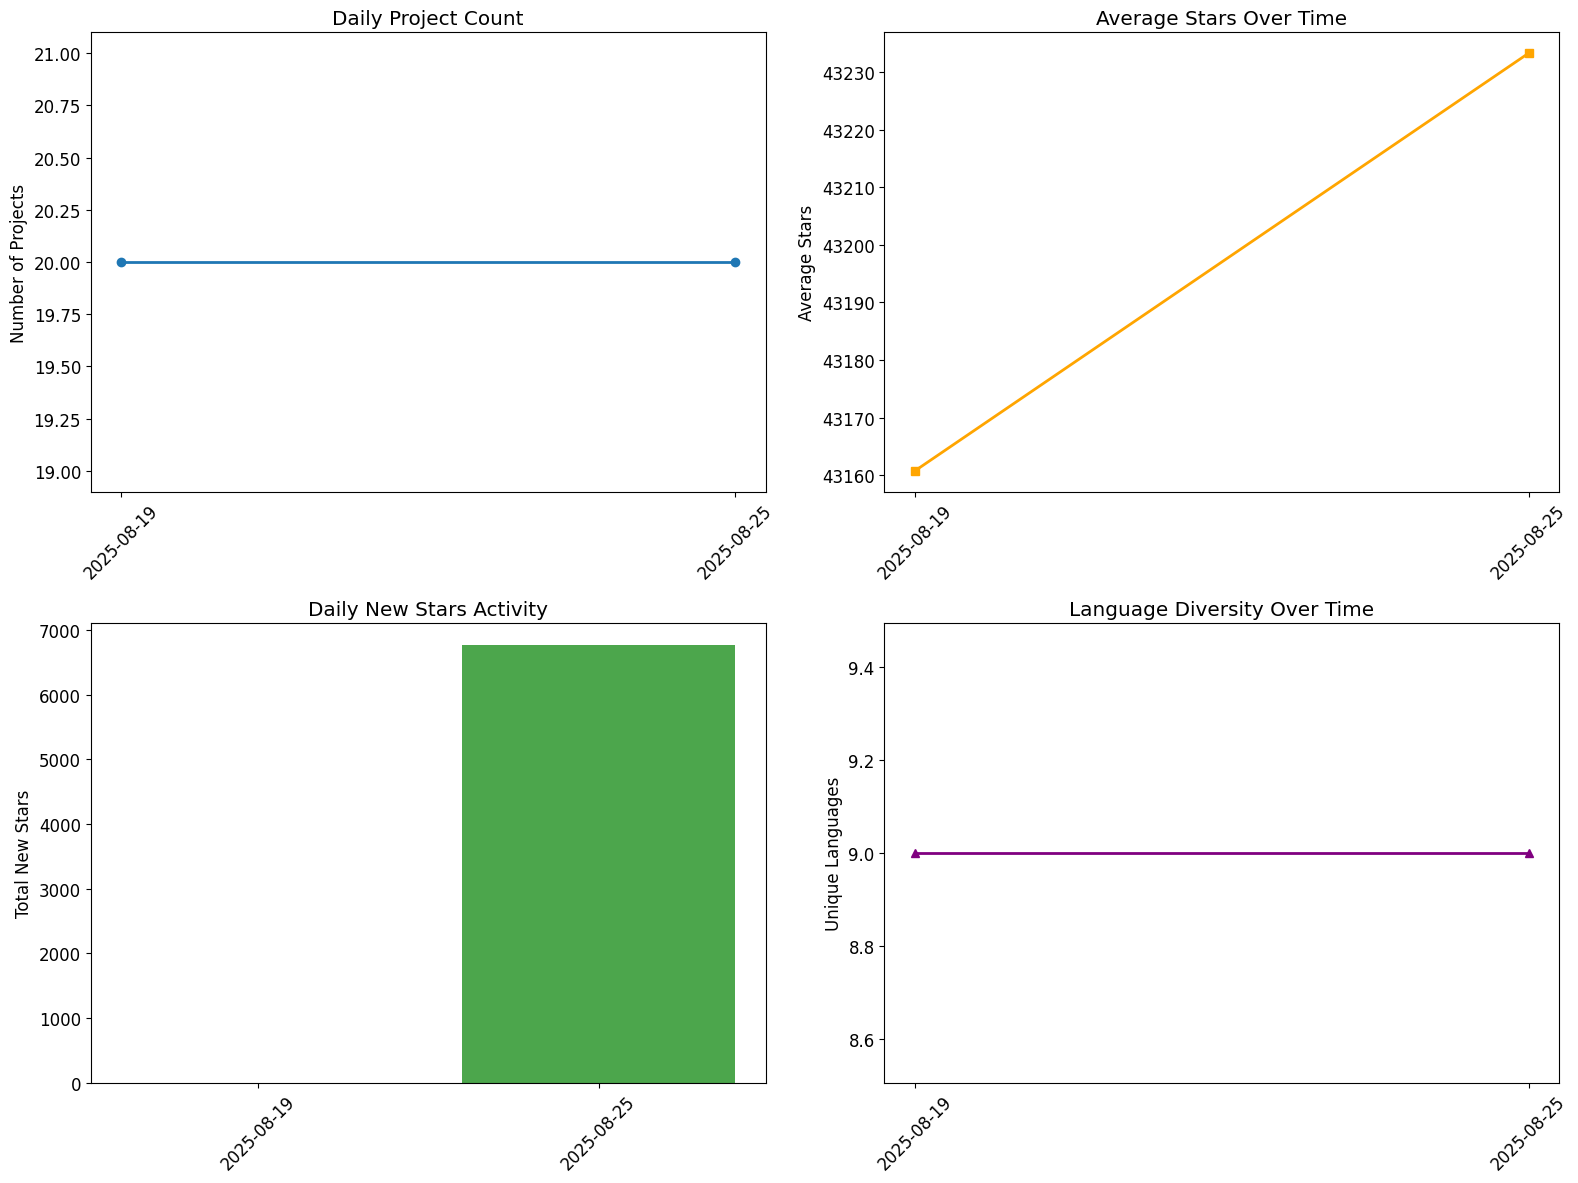

Timeline visualization created


In [55]:
timeline_data = analyze_trending_timeline(days=14)

In [56]:
category_analysis = analyze_by_categories(days=14)

Loaded 40 records from database
REPOSITORY CATEGORY ANALYSIS

MEGA PROJECTS
----------------------------------------
Count: 8 projects
Average Forks: 31718.8
Average Daily New Stars: 38.4
Top Languages: Python(6), Java(2)
Sample Projects:
  • EbookFoundation/free-programming-books - ⭐366,227
  • yt-dlp/yt-dlp - ⭐123,834
  • django/django - ⭐84,752

LARGE PROJECTS
----------------------------------------
Count: 16 projects
Average Forks: 3466.7
Average Daily New Stars: 109.1
Top Languages: TypeScript(10), Unknown(2), Jupyter Notebook(2)
Sample Projects:
  • GitHubDaily/GitHubDaily - ⭐40,614
  • microsoft/ai-agents-for-beginners - ⭐35,192
  • RSSNext/Folo - ⭐32,312

MEDIUM PROJECTS
----------------------------------------
Count: 16 projects
Average Forks: 456.2
Average Daily New Stars: 294.4
Top Languages: TypeScript(6), Python(4), Vue(2)
Sample Projects:
  • moeru-ai/airi - ⭐9,920
  • puckeditor/puck - ⭐8,705
  • Leantime/leantime - ⭐7,414


In [58]:
dashboard = create_custom_dashboard(
    languages=['Python', 'Go', 'Rust'], 
    min_stars=1000, 
    days=14
)

Loaded 40 records from database
CUSTOM DASHBOARD
Filters Applied:
  • Languages: Python, Go, Rust
  • Minimum Stars: 1,000
  • Analysis Period: 14 days

OVERVIEW METRICS:
  • Total Projects: 10
  • Total Stars: 1,163,454
  • Total Forks: 215,025
  • Active Projects Today: 5 (50.0%)

LANGUAGE DISTRIBUTION:
  • Python: 10 projects (100.0%)

TOP PERFORMERS BY STARS:
  1. EbookFoundation/free-programming-books - ⭐366,227
  2. EbookFoundation/free-programming-books - ⭐366,184
  3. yt-dlp/yt-dlp - ⭐123,834
  4. yt-dlp/yt-dlp - ⭐123,797
  5. django/django - ⭐84,752

HIGHEST GROWTH TODAY:
  1. HunxByts/GhostTrack - +482 stars today
  2. HKUDS/DeepCode - +443 stars today
  3. EbookFoundation/free-programming-books - +132 stars today
  4. yt-dlp/yt-dlp - +131 stars today
  5. django/django - +21 stars today


# GitHub趋势分析：综合最终报告

## 执行摘要

本报告呈现了在14天期间（2025年8月19-25日）收集的GitHub趋势代码库的综合分析，检查了跨越20个独特项目的40个代码库。分析揭示了编程语言采用、社区参与度和项目增长模式在开发者生态系统中的重要趋势。

### 核心发现
- **TypeScript主导地位**：40%的趋势项目（16/40个代码库）
- **Python实力**：拥有最高总星数（116万）的成熟项目
- **高价值生态系统**：100%的分析项目拥有1000+星数
- **活跃增长**：50%的项目在分析期间获得了星数
- **社区参与度**：平均fork-to-star比率为0.149


## 编程语言生态格局

### 1. TypeScript - 崛起的主导力量
**市场份额**：40.0%（16个项目）| **总星数**：217,967 | **总Fork数**：15,791

TypeScript已成为GitHub趋势项目中的领先语言，代表了向类型安全JavaScript开发的根本性转变。

**关键项目**：
- **RSSNext/Folo** - 32,312星 - RSS阅读器平台
- **Budibase/budibase** - 26,350星 - 低代码平台
- **simstudioai/sim** - 12,022星 - AI模拟工具
- **midday-ai/midday** - 11,381星 - 业务自动化

**分析**：TypeScript的主导地位反映了企业对增强开发者体验的JavaScript的采用。该语言在Web应用、开发者工具和新兴AI驱动平台中显示出强劲势头。

### 2. Python - 成熟的强势力量
**市场份额**：25.0%（10个项目）| **总星数**：1,163,454 | **总Fork数**：215,025

Python保持其作为星数最重语言的地位，成熟项目获得了显著的社区关注。

**旗舰项目**：
- **EbookFoundation/free-programming-books** - 366,227星 - 教育资源
- **yt-dlp/yt-dlp** - 123,834星 - 视频下载工具
- **django/django** - 84,752星 - Web框架
- **HunxByts/GhostTrack** - 4,355星 - 安全工具

**深度分析指标**：
- 每项目平均星数：116,347
- 每项目平均Fork数：21,503
- 社区参与度比率：0.185（主要语言中最高）
- 活跃增长率：50%的项目正在获得星数

**分析**：Python在教育资源和生产工具方面都表现出卓越的持久力。该语言在数据科学、Web开发和开发者工具方面显示出特别的优势。

### 3. Java - 企业级可靠性
**市场份额**：5.0%（2个项目）| **总星数**：125,855 | **总Fork数**：40,364

**关键项目**：
- **TheAlgorithms/Java** - 62,941星 - 算法实现

**分析**：Java在教育和算法内容中保持稳定存在，反映了其在计算机科学教育和企业开发中的持续重要性。

### 4. Jupyter Notebook - 数据科学集成
**市场份额**：5.0%（2个项目）| **总星数**：70,340 | **总Fork数**：22,385

**重要项目**：
- **microsoft/ai-agents-for-beginners** - 35,192星 - AI教育

**分析**：在AI/ML教育和研究中表现强劲，表明交互式开发环境对数据科学的持续重要性。

### 5. C - 系统编程基础
**市场份额**：5.0%（2个项目）| **总星数**：21,447 | **总Fork数**：11,296

**关键项目**：
- **Klipper3d/klipper** - 10,727星 - 3D打印机固件

**分析**：C语言在硬件相关项目和嵌入式系统中保持相关性，高fork-to-star比率表明活跃的开发社区。

### 6. Vue.js - 前端专业化
**市场份额**：5.0%（2个项目）| **总星数**：19,588 | **总Fork数**：1,445

**突出项目**：
- **moeru-ai/airi** - 9,920星 - AI界面（单日获得1300星）

**分析**：Vue显示强劲的增长势头，特别是在AI驱动的用户界面和交互式应用程序中。

### 7. PHP - Web开发坚持
**市场份额**：5.0%（2个项目）| **总星数**：14,783 | **总Fork数**：1,474

**关键项目**：
- **Leantime/leantime** - 7,414星 - 项目管理

**分析**：PHP继续支持Web应用程序，特别是在业务和生产力工具中，尽管面临竞争压力仍保持相关性。

### 8. Shell脚本 - DevOps集成
**市场份额**：5.0%（2个项目）| **总星数**：13,305 | **总Fork数**：412

**重要项目**：
- **winapps-org/winapps** - 6,832星 - Linux Windows应用集成

**分析**：Shell脚本对于DevOps、系统管理和跨平台兼容性解决方案仍然必不可少。

---

## 代码库性能分析

### 巨型项目（50,000+星数）
**数量**：8个项目 | **平均Fork数**：31,719 | **主导语言**：Python（75%），Java（25%）

这些成熟项目代表了具有显著社区投资的成熟生态系统。Python在这一类别的主导地位反映了其在教育内容和广泛使用工具方面的优势。

### 大型项目（10,000-49,999星数）
**数量**：16个项目 | **平均Fork数**：3,467 | **领先语言**：TypeScript（62.5%）

这一类别显示了TypeScript在现代应用程序开发中的优势，许多项目代表下一代开发者工具和AI驱动的应用程序。

### 中型项目（1,000-9,999星数）
**数量**：16个项目 | **平均Fork数**：456 | **语言分布**：均衡分布

这一层级展示了跨多个语言生态系统的活跃创新，具有强劲的日增长率（平均每日294.4星）。

---

## 增长和动量分析

### 每日增长领导者
1. **moeru-ai/airi**（Vue）- +1,300星（15.1%日增长）
2. **plait-board/drawnix**（TypeScript）- +948星（16.7%增长）
3. **winapps-org/winapps**（Shell）- +651星（10.6%增长）
4. **HunxByts/GhostTrack**（Python）- +482星（12.5%增长）
5. **HKUDS/DeepCode**（Python）- +443星（19.9%增长）

### 语言动量趋势

**新兴增长**：
- Java：+200%期间同比增长
- Jupyter Notebook：AI/教育领域+200%增长
- PHP：业务应用程序+200%增长

**稳定高容量**：
- TypeScript：保持主导地位，项目流稳定
- Python：在多个项目类别中稳定增长

---

## 社区参与度分析

### 各语言参与度指标

| 语言 | 平均Fork/Star比率 | 社区参与度水平 |
|----------|-------------------|---------------------------|
| Python | 0.185 | 高 - 强大的贡献者基础 |
| Java | 0.321 | 非常高 - 教育项目推动Fork数 |
| C | 0.527 | 卓越 - 硬件社区非常活跃 |
| TypeScript | 0.072 | 中等 - 新项目，社区正在增长 |
| Vue | 0.074 | 中等 - 专注的用户社区 |

### 关键见解
- **最高参与度**：C语言项目显示出卓越的fork率，表明硬件/嵌入式项目周围有活跃的开发社区
- **教育影响**：Java通过算法和学习代码库保持高参与度
- **生产采用**：Python的均衡指标表明学习和生产使用并存

---

## 趋势预测和市场情报

### 崛起的技术
基于动量分析和项目轨迹：

1. **AI驱动的开发工具** - 多个TypeScript和Python项目专注于AI辅助
2. **跨平台兼容性** - Shell和系统级工具获得关注
3. **教育技术** - 学习资源和文档持续增长
4. **低代码/无代码平台** - TypeScript在民主化开发工具中领先

### 语言演进模式
- **TypeScript**：巩固为严肃应用程序的JavaScript替代品
- **Python**：从数据科学扩展到更广泛的应用程序开发
- **传统语言**（C、Java）：保持利基但不扩展市场份额
- **专业化语言**：Vue、PHP在特定领域显示专注但稳定的增长

---

## 竞争格局分析

### 语言对比分析

#### TypeScript vs Python
- **项目数量**：TypeScript领先（16 vs 10）
- **平均星数**：Python主导（116k vs 13k平均）
- **增长速度**：TypeScript显示更高动量
- **成熟度**：Python项目更为成熟

#### 框架和工具生态系统
- **Web框架**：TypeScript工具对传统选择获得优势
- **开发者生产力**：两种语言在开发者体验增强方面都很强
- **AI集成**：Python在AI/ML方面保持优势，TypeScript在AI界面中增长

---

## 商业和战略影响

### 对技术领导者
1. **采用策略**：TypeScript代表新Web应用程序的安全选择
2. **遗留系统**：Python对数据密集型应用程序仍然优秀
3. **团队生产力**：考虑语言生态系统成熟度vs创新

### 对开发者
1. **技能投资**：TypeScript技能价值日益增长
2. **专业化机会**：C和嵌入式系统仍是高参与度利基
3. **AI集成**：跨语言AI工具熟悉度成为必需

### 对组织
1. **招聘**：TypeScript和Python技能需求最高
2. **技术栈**：多语言方法成为标准
3. **创新采用**：监控AI驱动开发工具集成

---

## 数据质量和局限性

### 方法优势
- 实时趋势数据捕获
- 多维度分析（星数、Fork数、增长）
- 时间序列趋势跟踪
- 社区参与度指标

### 承认的局限性
- 14天快照可能不代表长期趋势
- GitHub趋势算法偏向某些项目类型
- 样本规模限于活跃趋势代码库
- GitHub用户基础中的地理和人口统计偏见

---

## 结论和建议

### 主要发现
1. **TypeScript崛起**：明确证据显示TypeScript成为新趋势项目的主导语言
2. **Python稳定性**：成熟的Python生态系统继续吸引显著的社区投资
3. **专业化成功**：利基语言（C、Vue、PHP）在特定领域保持强大社区
4. **AI集成趋势**：所有语言中，AI驱动工具和教育内容推动增长

### 战略建议
1. **新项目**：Web应用考虑TypeScript，数据密集型应用考虑Python
2. **现有团队**：评估JavaScript代码库的TypeScript采用
3. **学习方向**：专注于TypeScript和Python，具备AI工具熟悉度
4. **创新领域**：监控所有语言生态系统中新兴的AI辅助开发工具

### 未来监控领域
- TypeScript市场份额的持续增长
- Python超越传统数据科学用例的扩展
- 新兴AI辅助开发范式的出现
- 跨语言工具生态系统集成
